In [1]:
#integrated gradients, 10/29/2023
import sys
sys.path.insert(0,'../src')
import tensorflow as tf
import keras as tfk
tfkl = tf.keras.layers
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import util
import GA_util
import interpretation

In [2]:
model = tfk.models.load_model('../models/simulated_classifier_10_30_23')

2025-03-18 18:26:55.031565: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2025-03-18 18:26:55.031590: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Metal device set to: Apple M1 Ultra


In [3]:
sequences = np.load('../data/simulated_dataset_10_23_30.npy')
targets = np.load('../data/simulated_dataset_targets_10_23_30.npy')

ppms = GA_util.prototype_ppms_fast(sequences)

In [4]:
model([sequences,ppms]).shape

TensorShape([80000, 5])

In [5]:
def compute_gradients_classifier(model,sequences,ppms=None,return_val=None,target_class=0):
    #If no structure matrix is passed, calculate one based on the baseline sequence
    #return val can be 'seq', 'ppm', or None; None defaults to sequence returns
    #target_class is an integer indexign which model output you are interested in
    
    if return_val is None:
        return_val = 'seq'
    
    if ppms is None:
        #Need to select the -1 sequence specifically because it will be the ground truth while priors are interpolations
        ppms = GA_util.create_ppms_fast(np.expand_dims(sequences[-1,:,:],axis=0))

        ppms = interpolate_ppm(ppms,m_steps = sequences.shape[0]-1)
    
    
    if return_val == 'seq':
        with tf.GradientTape() as tape:
            
            tape.watch(sequences)
            output = model([sequences,ppms])[:,target_class]
            
        return tape.gradient(output, sequences)
    
    
    elif return_val == 'ppm':
        with tf.GradientTape() as tape:
            tape.watch(ppms)
            output = model([sequences,ppms])[:,target_class]
        return tape.gradient(output,ppms)

AATCGTTTTATAGATTCTATCTATTTCATCAACAGAGGAGAGATGAAATGGATAGAATC
(1, 4, 59)
(1, 59, 59)
(51, 4, 59)


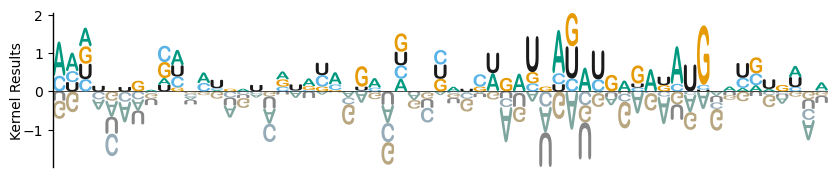

(51, 59, 59)


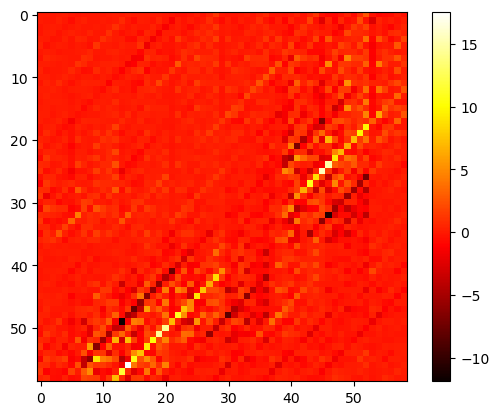

CATTGATAGTTTTAATATTCGCCAGGATACAACAGAGGAGAGTATCCATGCGAATATTA
(1, 4, 59)
(1, 59, 59)
(51, 4, 59)


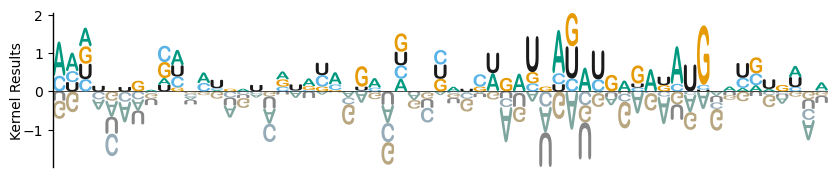

(51, 59, 59)


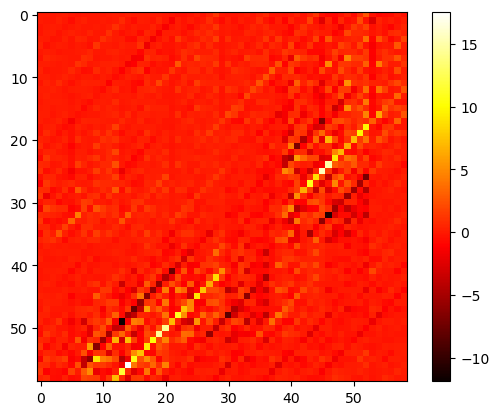

AGACTTCACACTGAGGTACCGCTCCATGAGAACAGAGGAGACTCATGATGCGGTACCTC
(1, 4, 59)
(1, 59, 59)
(51, 4, 59)


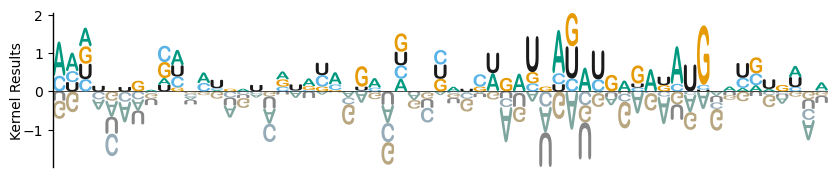

(51, 59, 59)


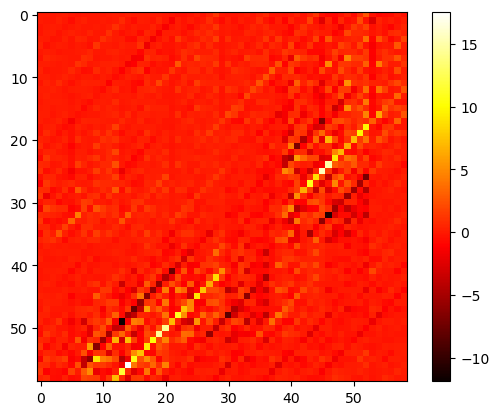

In [8]:
TARGET_CLASS = 0

for i in range(3):

    best = sequences[i:i+1,:,:] #indexing this way ot keep the shape 3d
    print(GA_util.unencode(best[0,:,:]))
    print(best.shape)


    best_ppms = GA_util.prototype_ppms_fast(best)
    print(best_ppms.shape)

    best_ipts = interpretation.interpolate_sequence(best[0,:,:])

    print(best_ipts.shape)
    best_ppms = interpretation.interpolate_ppm(best_ppms[0,:,:])
    best_grads = interpretation.compute_gradients_classifier(model,best_ipts,best_ppms,target_class=TARGET_CLASS)
    best_attn = interpretation.integral_approximation(best_grads)
    interpretation.plot_kernel_logo(best_attn)
    plt.show()


    best_ppm_grads = interpretation.compute_gradients_classifier(model,best_ipts,best_ppms,return_val='ppm',target_class=TARGET_CLASS)
    print(best_ppm_grads.shape)
    best_ppm_attn = interpretation.integral_approximation(best_ppm_grads)
    # plt.figure(figsize=[15,15])
    plt.imshow(best_ppm_attn,cmap='hot')
    plt.colorbar()
    plt.show()

AGACTTCACACTGAGGTACCGCTCCATGAGAACAGAGGAGACTCATGATGCGGTACCTC


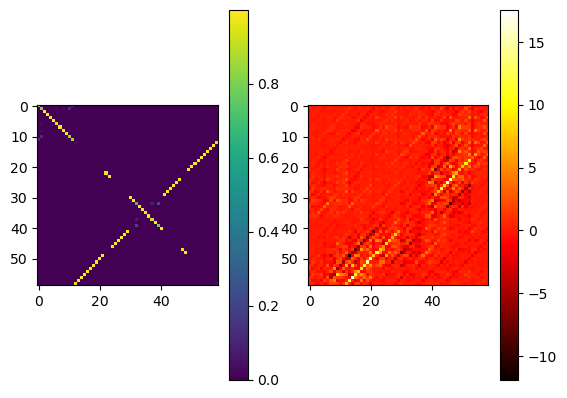

In [9]:
import nupack as n

tmp = util.unencode(best[0,:,:])
print(tmp)

matrix = n.pairs(strands=[tmp],model=n.Model())

plt.figure()
plt.subplot(1,2,1)
plt.imshow(matrix.array)
plt.colorbar()

plt.subplot(1,2,2)
plt.imshow(best_ppm_attn,cmap='hot')
plt.colorbar()
# plt.savefig('../figures/classifier_figs/interpret_structure_decoy.svg',transparent=True,dpi=1000)